# Reduced coverage experiments
Where the set of entries contrained in one thesaurus is constrained to match another, smaller thesaurus. This lets us look at performance differences due to 

 - higher coverage of space of all words/phrases (due to different filtering or algorithm specifics), versus 
 - better vector quality
 
There are currently (19-5-15) two sets of such experiments, both for NPs only:
 - w2v vectors reduced to the coverage of count-windows vectors
 - count-windows reduced to coverage of Baroni vector

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from copy import deepcopy
from notebooks.common_imports import *
from gui.output_utils import *
from gui.user_code import pretty_names
from pprint import pprint

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Users/miroslavbatchkarov/NetBeansProjects/ExpLosion


In [2]:
def plot_matching(exp_with_constraints, labels=None, rotation=0):
    matching = []
    for e in exp_with_constraints:
        settings = settings_of(e.id)
        settings['expansions__entries_of_id'] = None
        matching.append(Experiment.objects.get(**settings))
    
    ids1 = list(exp_with_constraints.values_list('id', flat=True))
    ids2 = [x.id for x in matching]
    print(ids1, '--->', ids2)
    if not labels:
        labels = ['%s-%s'%(a.id, b.id) for a,b in zip(exp_with_constraints, matching)]
    with sns.color_palette("cubehelix", 2):
        diff_plot_bar([ids1, ids2], ['Limited', 'Unlimited'],
                      labels, rotation=rotation, hue_order=['Unlimited', 'Limited'])

# count windows vectors (add, mult, ...) reduced to Baroni's coverage
we know they are better and have a higher coverage, so can reducing the coverage reduce the accuracy too

[188, 190, 192, 194] ---> [27, 28, 29, 30]
Calculating CI for exp 188
Calculating CI for exp 27
Calculating CI for exp 190
Calculating CI for exp 28
Calculating CI for exp 192
Calculating CI for exp 29
Calculating CI for exp 194
Calculating CI for exp 30


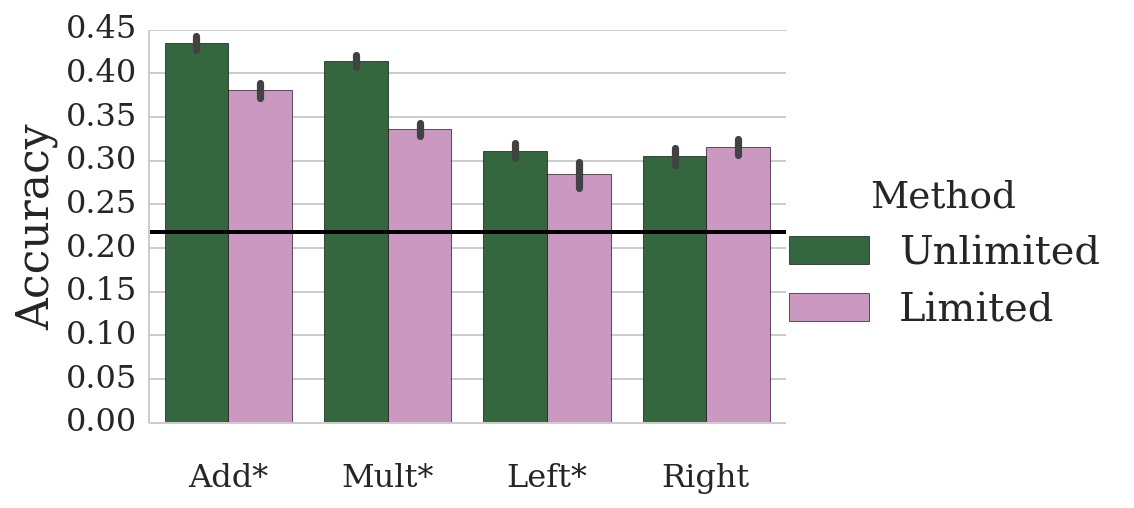

In [3]:
experiments = Experiment.objects.filter(expansions__entries_of__isnull=False, 
                                        expansions__entries_of__composer='Baroni')
names = [n.expansions.vectors.composer for n in experiments]

plot_matching(experiments, labels=names)
plt.axhline(random_vect_baseline(), c='k');
plt.savefig('plot-reduced-coverage1.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# word2vec reduced to coverage of count windows (there shouldn't be a large difference)

[187, 189, 191, 193] ---> [34, 35, 36, 37]
Calculating CI for exp 187
Calculating CI for exp 189
Calculating CI for exp 191
Calculating CI for exp 193


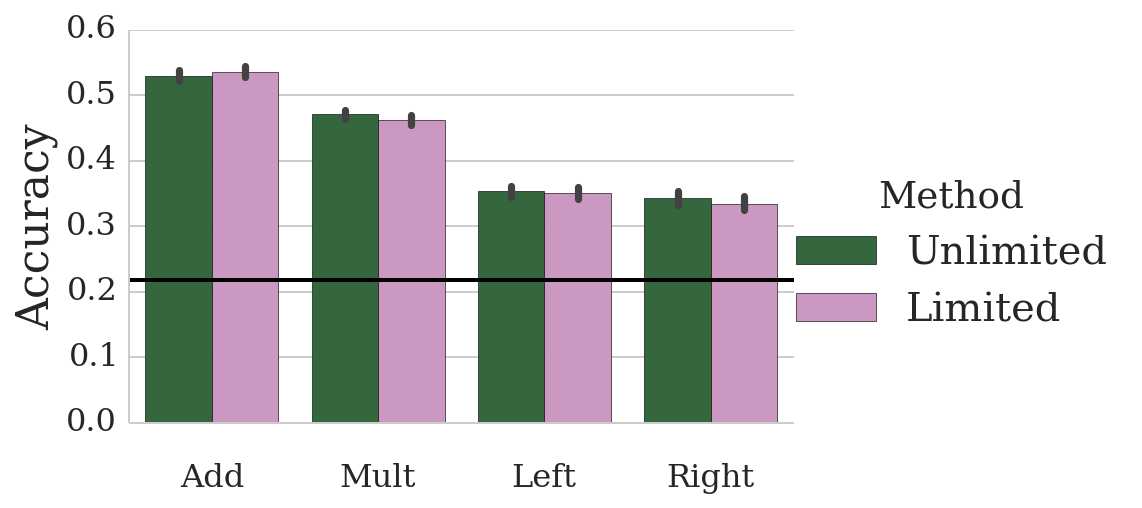

In [4]:
exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                    expansions__entries_of__algorithm='count_windows'
                                   ).exclude(expansions__entries_of__composer='Baroni')
names = [n.expansions.vectors.composer for n in exp_ids]
plot_matching(exp_ids, labels=names)
plt.axhline(random_vect_baseline(), c='k');
plt.savefig('plot-reduced-coverage2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# wiki-100 reduced to coverage of wiki-15 

[282, 283, 284, 285] ---> [34, 35, 36, 37]
Calculating CI for exp 282
Calculating CI for exp 283
Calculating CI for exp 284
Calculating CI for exp 285


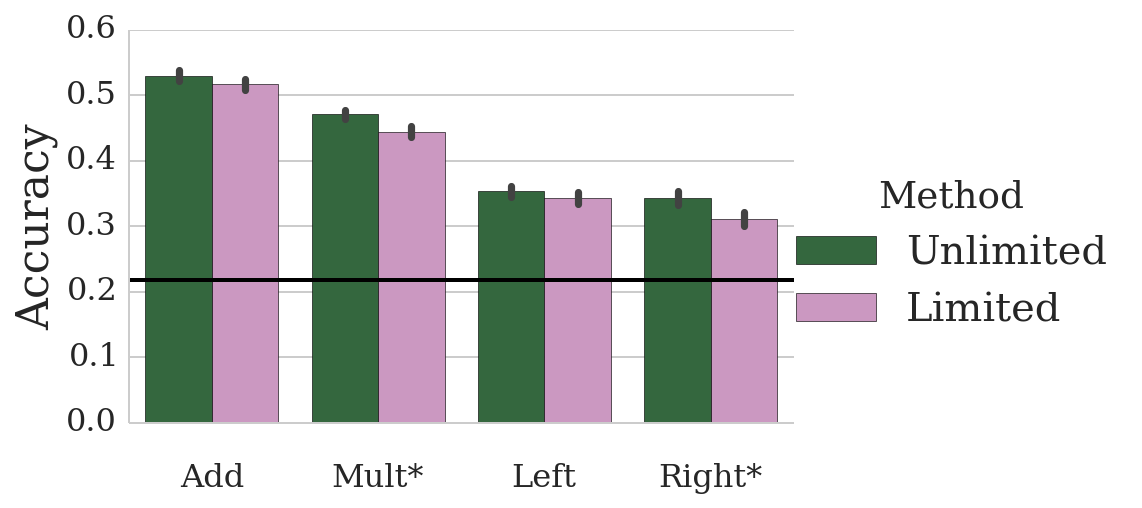

In [5]:
exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                    expansions__vectors__unlabelled_percentage=100,
                                    expansions__entries_of__unlabelled_percentage=15)
names = [n.expansions.vectors.composer for n in exp_ids]
plot_matching(exp_ids, labels=names)
plt.axhline(random_vect_baseline(), c='k');
plt.savefig('plot-reduced-coverage3.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Learning curve with reduced coverage
An extended version of the above cell

In [6]:
constrained_exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                    expansions__entries_of__unlabelled_percentage__in=[1, 10],
                                    expansions__vectors__composer='Add').values_list('id', flat=True)
print(constrained_exp_ids)

[324, 325, 326, 327, 328, 329, 330, 331, 332, 333]


In [7]:
unconstrained_exp_ids = []
unconstrained_exp_ids = set()
for eid in constrained_exp_ids:
    s = settings_of(eid)
    s['expansions__entries_of_id'] = None
    del s['expansions__vectors__unlabelled_percentage']
    unconstrained_exp_ids.update(set(Experiment.objects.filter(**s).values_list('id', flat=True)))
print(unconstrained_exp_ids, '-->', constrained_exp_ids)

{34, 101, 102, 103, 104, 105, 106, 75} --> [324, 325, 326, 327, 328, 329, 330, 331, 332, 333]


In [8]:
names = {'percent':'expansions__vectors__unlabelled_percentage',
         'reduced_to':'expansions__entries_of__unlabelled_percentage'}
df1 = dataframe_from_exp_ids(unconstrained_exp_ids, names)
# df1['kind'] = 'Unlimited'
df2 = dataframe_from_exp_ids(constrained_exp_ids, names)
# df2['kind'] = 'Limited'

Accuracy has 4000 values
percent has 4000 values
folds has 4000 values
reduced_to has 4000 values
Calculating CI for exp 324
Calculating CI for exp 325
Calculating CI for exp 326
Calculating CI for exp 327
Calculating CI for exp 328
Calculating CI for exp 329
Calculating CI for exp 330
Calculating CI for exp 331
Calculating CI for exp 332
Calculating CI for exp 333
Accuracy has 5000 values
percent has 5000 values
folds has 5000 values
reduced_to has 5000 values


In [9]:
df = pd.concat([df1, df2], ignore_index=True).convert_objects(convert_numeric=True).fillna(100)

In [10]:
df[df.folds==0]

,Accuracy,folds,percent,reduced_to
0,0.516205,0,100,100
500,0.295145,0,1,100
1000,0.428876,0,10,100
1500,0.475040,0,20,100
2000,0.526498,0,40,100
2500,0.509483,0,60,100
3000,0.507105,0,80,100
3500,0.458260,0,15,100
4000,0.421335,0,20,1
4500,0.427663,0,40,1


/Users/miroslavbatchkarov/anaconda/envs/py3k/lib/python3.3/site-packages/matplotlib/backends/backend_pdf.py:2184: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)

  different = bool(ours != theirs)



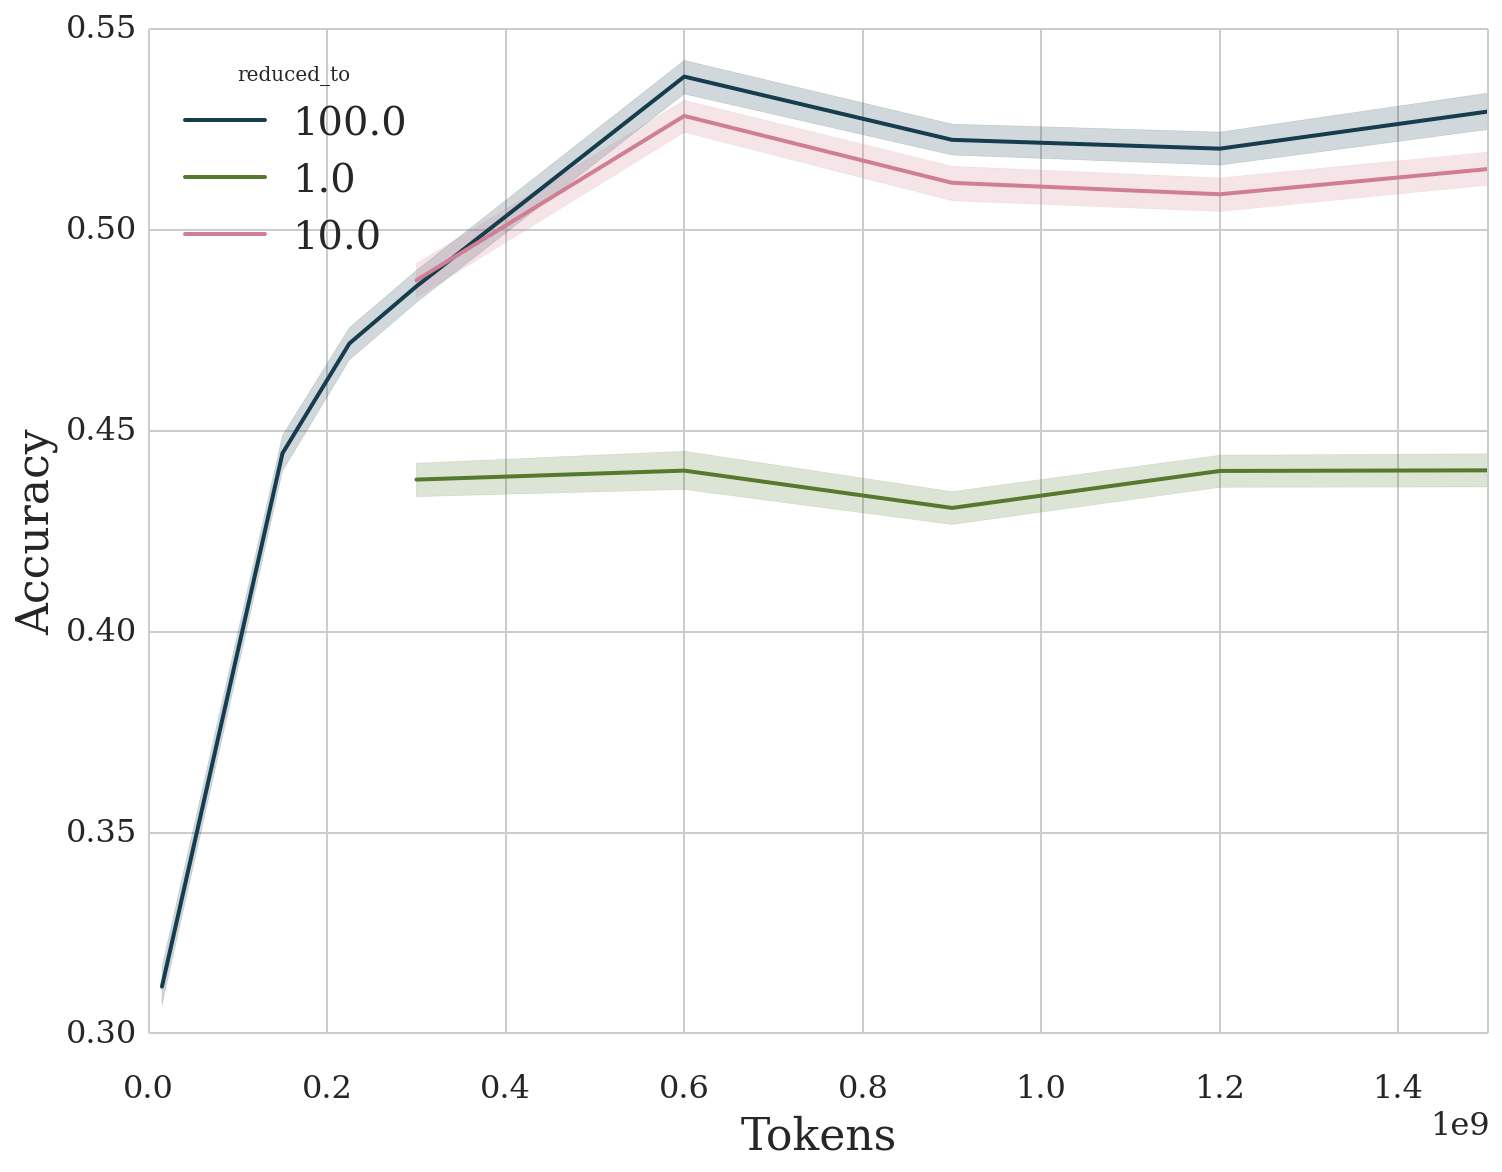

In [11]:
df['Tokens'] = df.percent * 1500000000 / 100
with sns.color_palette("cubehelix", 4):
    ax = sns.tsplot(df, time='Tokens', unit='folds', condition='reduced_to', value='Accuracy')
plt.xlim(0, df.Tokens.max())
# plt.axvline(15 * 1500000000/ 100, color='red', linestyle='dotted');
# plt.axvline(1 * 1500000000/ 100, color='green', linestyle='dotted');
plt.savefig('plot-learning-curve-with-reduction.pdf', format='pdf', dpi=300)